### NLP in a nutshell

we will build a NLP (Natural Language Processing) pipeline With the following steps:

Sentence Segmentation: Breaking the phrase into separate Sentences

Word Tokenization: Breaking the sentence to separate words

Stemming: Transforming the words to their roots

Lemmatization: It produces the root word which has a meaning

Identifying Stop Words: The words such as 'is', 'and', 'the',... should be filtered out before any statistical analysis

Dependency Parsing: Finding how the words in a sentence are related to eachother

POS tags: POS stands for Parts Of Speech. It indicates the gramatical role of a word (noun, verb, adjective, ...)

Named Entity Recognition: The process of recognizing a named entity like a movie, car, person, brand, ...

Chunking: is the process of picking the individual information and group them into meaningful mixtures.

We will also makes use of Support Vector Machine (SVM) method for our classification. If the data points are linearly separable, we can use a linear kernel or hyperplane. Otherwise, we will go ahead with polynomial or radial basis functions.

We can also utilize Random Forest algorithm. In this algorithm, we randomly create a forest and several trees. A higher number of trees will result in more accurate results.

Random Forest algorithm can help us when we want to decide based on a number of parameters, e.g. when buying a house. It randomly selects a number of parameters and builds a decision tree based on that group. Clearly, the more trees we have, the more accurate result we will reach. The class that has the majority of votes by the trees will be selected as our predicted class.

So, after this pretty log introduction, let's go ahead with the fun part, code!

Let us first install and import the necessary libraries!

In [144]:
!pip install wordcloud
!pip install -U spacy

In [145]:
import string
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


sb.set()

In [146]:
data = pd.read_csv('fake_job_postings.csv')
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [147]:
print("Data type : ", type(data))
print("Data dims : ", data.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (17880, 18)


In [148]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [149]:
columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

In [150]:
data.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent'],
      dtype='object')

In [151]:
data.fillna('',inplace=True)

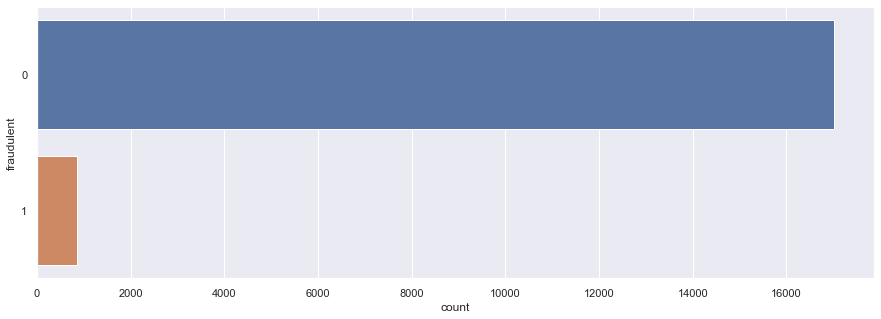

In [152]:
plt.figure(figsize=(15,5))
sb.countplot(y='fraudulent', data = data)
plt.show()

In [153]:
data['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [154]:
country = exp = dict(data.location.value_counts())
del exp['']

In [155]:
country

{'GB, LND, London': 718,
 'US, NY, New York': 658,
 'US, CA, San Francisco': 472,
 'GR, I, Athens': 464,
 'US, , ': 339,
 'US, TX, Houston': 269,
 'US, IL, Chicago': 255,
 'US, DC, Washington': 251,
 'DE, BE, Berlin': 221,
 'NZ, N, Auckland': 218,
 'US, CA, Los Angeles': 185,
 'GB, , London': 179,
 'US, TX, Austin': 174,
 'US, CA, San Diego': 164,
 'GB, , ': 138,
 'US, GA, Atlanta': 135,
 'GB, LND, ': 131,
 'US, OR, Portland': 131,
 'CA, ON, Toronto': 123,
 'US, MA, Boston': 117,
 'US, PA, Philadelphia': 114,
 'US, MI, Detroit': 112,
 'US, NY, Brooklyn': 109,
 'US, TX, Dallas': 104,
 'US, VA, Virginia Beach': 95,
 'US, OH, Cleveland': 95,
 'GR, , ': 94,
 'US, OH, Cincinnati': 91,
 'US, NC, Charlotte': 89,
 'US, MO, St. Louis': 88,
 'US, NY, New York City': 85,
 'AU, NSW, Sydney': 82,
 'US, NV, Las Vegas': 82,
 'US, CA, Santa Monica': 80,
 'US, AZ, Phoenix': 79,
 'CA, BC, Vancouver': 79,
 'US': 63,
 'EE, 37, Tallinn': 60,
 'GR, , Athens': 60,
 'US, MN, Minneapolis': 59,
 'US, NY, Albany

In [156]:
def split(location):
    l = location.split(',')
    return l[0]
data['country'] = data['location'].apply(split)

In [157]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [158]:
specificCountry = dict(data.country.value_counts()[:33])
del specificCountry['']
specificCountry

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80,
 'HK': 77,
 'PL': 76,
 'EE': 72,
 'IL': 72,
 'FR': 70,
 'ES': 66,
 'AE': 54,
 'EG': 52,
 'SE': 49,
 'RO': 46,
 'DK': 42,
 'ZA': 40,
 'BR': 36,
 'IT': 31,
 'FI': 29,
 'PK': 27,
 'LT': 23,
 'MY': 21,
 'QA': 21}

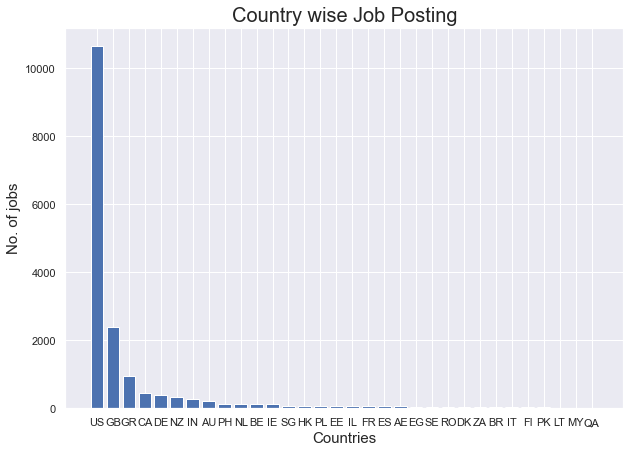

In [159]:
plt.figure(figsize=(10,7))
plt.bar(specificCountry.keys(), specificCountry.values())
plt.title('Country wise Job Posting',size=20)
plt.ylabel('No. of jobs',size=15)
plt.xlabel('Countries',size=15)
plt.show()

In [160]:
# filtering the rows containging US
df = data[data['country'].str.contains('US')]
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
5,Accounting Clerk,"US, MD,",,,Job OverviewApex is an environmental consultin...,,,,,,,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17872,Product Manager,"US, CA, San Francisco",Product Development,Flite delivers ad innovation at scale to the w...,Flite's SaaS display ad platform fuels the wor...,BA/BS in Computer Science or a related technic...,Competitive baseAttractive stock option planMe...,,,Internet,Product Management,0,US
17873,Recruiting Coordinator,"US, NC, Charlotte",,,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,,,,Utilities,,0,US
17874,JavaScript Developer,"US, ,",,,"Sr, JavaScript Developer Experience : 4-10 yea...",,,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0,US
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US


In [161]:
df[df['fraudulent']==0].title.value_counts()[:10]

English Teacher Abroad                                295
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate                            136
English Teacher Abroad                                 89
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 74
Graduates: English Teacher Abroad                      55
Software Engineer                                      46
Customer Service Team Lead                             39
Project Manager                                        32
Name: title, dtype: int64

In [162]:
df[df['fraudulent']==1].title.value_counts()[:10]

Home Based Payroll Typist/Data Entry Clerks Positions Available    21
Cruise Staff Wanted *URGENT*                                       21
Data Entry Admin/Clerical Positions - Work From Home               21
Customer Service Representative                                    17
Administrative Assistant                                           16
Network Marketing                                                  10
Payroll Clerk                                                      10
Account Sales Managers $80-$130,000/yr                             10
Payroll Data Coordinator Positions - Earn $100-$200 Daily          10
Data Entry                                                          9
Name: title, dtype: int64

In [163]:
df.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'country'],
      dtype='object')

In [164]:
df['text'] = df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']


/var/folders/v6/026h9x2j27q4sytwzzv8q_200000gn/T/ipykernel_38231/1618608940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']


In [165]:
df.head()

,fraudulent,country,text
0,0,US,"Marketing Intern We're Food52, and we've creat..."
2,0,US,Commissioning Machinery Assistant (CMA) Valor ...
3,0,US,Account Executive - Washington DC Our passion ...
4,0,US,Bill Review Manager SpotSource Solutions LLC i...
5,0,US,Accounting Clerk Job OverviewApex is an envir...


In [166]:
del df['country']

In [167]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...
5,0,Accounting Clerk Job OverviewApex is an envir...


In [168]:
fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

(-0.5, 1599.5, 599.5, -0.5)

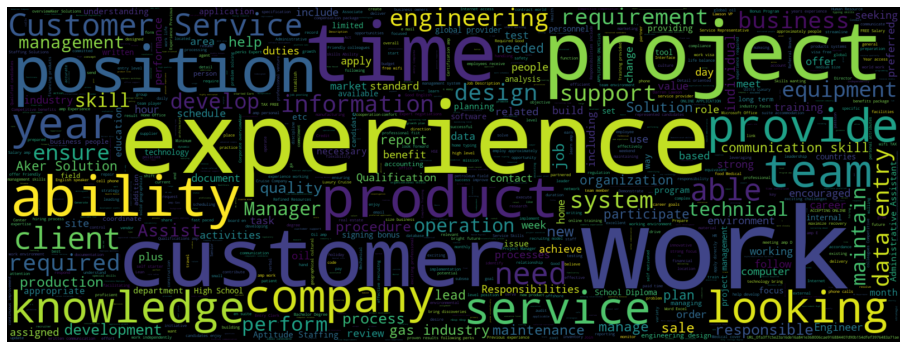

In [169]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size =3, max_words = 3000, width=1600, height=600, stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc, interpolation= 'bilinear') 
plt.axis('off')

(-0.5, 1599.5, 599.5, -0.5)

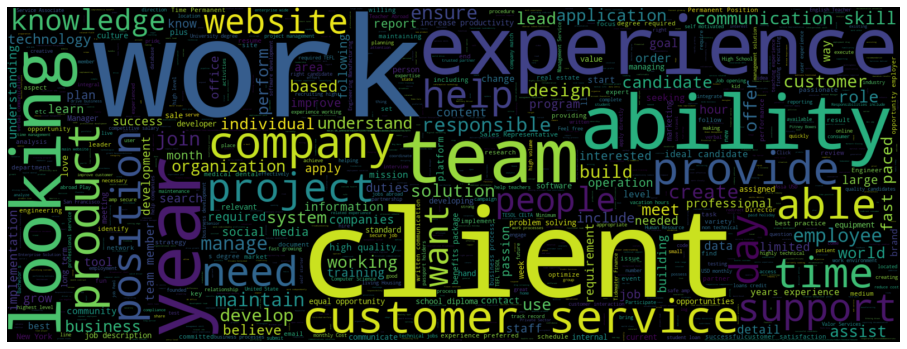

In [170]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size =3, max_words = 3000, width=1600, height=600, stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc, interpolation= 'bilinear') 
plt.axis('off')

In [171]:
!pip install spacy && python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 12.8 MB 4.8 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [172]:
punctuations = string.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    
    #lemitize each token and converting to lowercase
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    
    #Removing all the stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    #Returning processed words of token
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return{}
    
#Cleaning the text
def clean_text(text):
    return text.strip().lower()

In [173]:
df['text'] = df['text'].apply(clean_text)

/var/folders/v6/026h9x2j27q4sytwzzv8q_200000gn/T/ipykernel_38231/1163271480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(clean_text)


In [174]:
cv = TfidfVectorizer(max_features=100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(['text'], axis=1, inplace=True)
main_df = pd.concat([df1, df],axis=1)

/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/v6/026h9x2j27q4sytwzzv8q_200000gn/T/ipykernel_38231/931617068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['text'], axis=1, inplace=True)


In [175]:
main_df.head()

,ability,about,all,amp,an,and,are,as,at,based,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.042884,0.000000,0.036541,0.000000,0.756091,0.000000,0.078531,0.000000,0.0,...,0.000000,0.000000,0.184225,0.051932,0.076488,0.00000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.171589,0.041641,0.091972,0.395877,0.115048,0.000000,0.000000,0.0,...,0.000000,0.063592,0.303242,0.059180,0.000000,0.00000,0.000000,0.100553,0.077901,NaN
2,0.021952,0.000000,0.018223,0.000000,0.097675,0.692462,0.000000,0.031680,0.038365,0.0,...,0.025303,0.050651,0.074318,0.047137,0.000000,0.10987,0.018244,0.053394,0.062048,0.0
3,0.000000,0.000000,0.066336,0.040246,0.029630,0.607681,0.083395,0.115324,0.000000,0.0,...,0.000000,0.000000,0.157814,0.028598,0.042121,0.00000,0.033207,0.032395,0.112936,0.0
4,0.000000,0.038135,0.000000,0.000000,0.143541,0.599673,0.089778,0.046556,0.028190,0.0,...,0.000000,0.000000,0.054608,0.023090,0.068017,0.00000,0.026811,0.000000,0.030395,0.0


In [197]:
main_df = main_df.dropna()

In [198]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [199]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4351, 100)
(4351,)
(1866, 100)
(1866,)


## Random forest

In [200]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion='entropy')
model = rfc.fit(X_train, y_train)

In [201]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.9330117899249732

In [202]:
print("Classification Report\n")
print(classification_report(y_test, pred))
print("Confussion Matrix\n")
print(confusion_matrix(y_test, pred))

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1759
         1.0       0.05      0.01      0.02       107

    accuracy                           0.93      1866
   macro avg       0.50      0.50      0.49      1866
weighted avg       0.89      0.93      0.91      1866

Confussion Matrix

[[1740   19]
 [ 106    1]]


### Logistic Regression

In [203]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model1 = lr.fit(X_train, y_train)
prediction = lr.fit(X_train,y_train)

In [204]:
pred = lr.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.9426580921757771

In [205]:
print('Classification Report\n')
print(classification_report(y_test,pred))
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1759
         1.0       0.00      0.00      0.00       107

    accuracy                           0.94      1866
   macro avg       0.47      0.50      0.49      1866
weighted avg       0.89      0.94      0.91      1866

Confusion Matrix
[[1759    0]
 [ 107    0]]


/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
